In [13]:
%run ../utils/point_evaluation.py

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
from sklearn.linear_model import LinearRegression

### Confusion matrices

Confusion matrices for one month data

Common dates in AIS, GFW, and PLE:
[20220710]

GFW Performance Metrics:
tp: 29.0000
fp: 163.0000
fn: 93.0000
precision: 0.1510
recall: 0.2377
f1: 0.1847
accuracy: 0.1018

PLE Performance Metrics:
tp: 51.0000
fp: 994.0000
fn: 71.0000
precision: 0.0488
recall: 0.4180
f1: 0.0874
accuracy: 0.0457


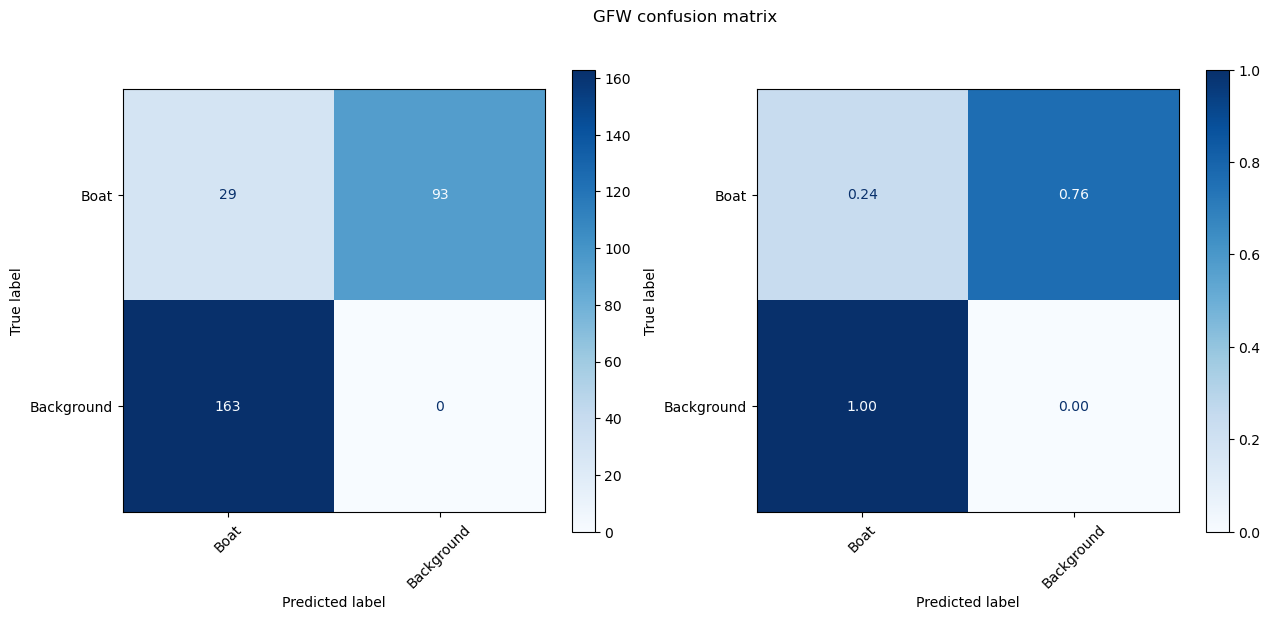

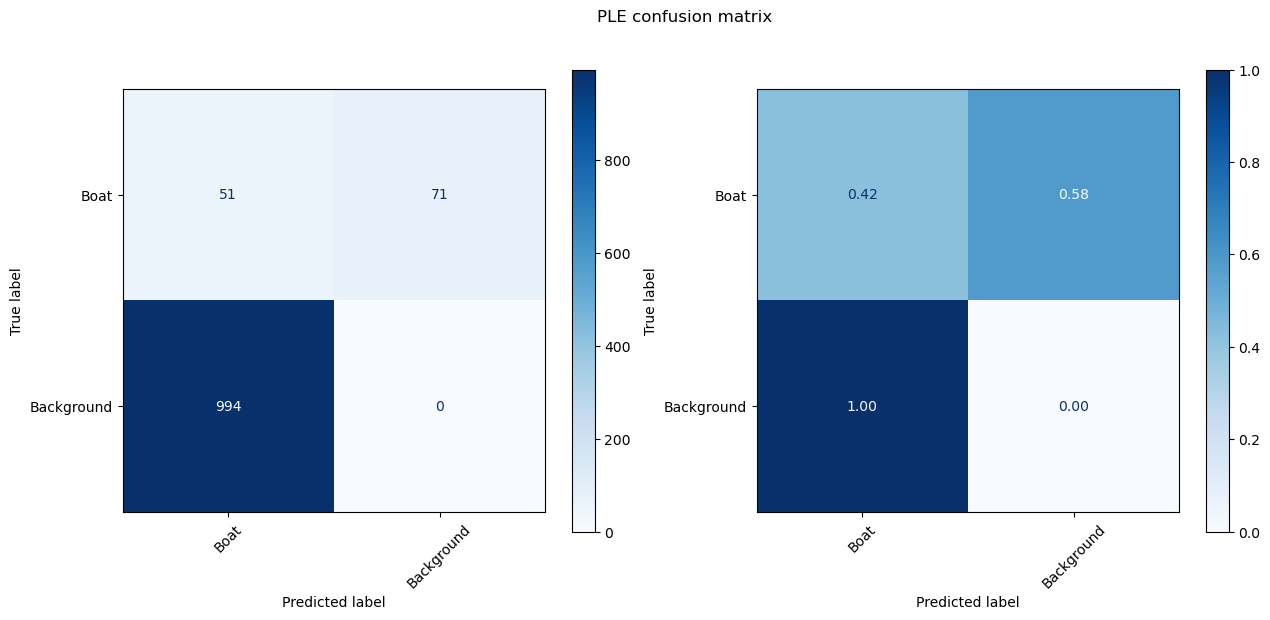

In [15]:
max_distances = [100, 500]
aoi_id = 5
yearmon = 202207

# Load ais
gdf_ais = gpd.read_file(f'../AIS/database/data_rearranged/ais_{aoi_id}_{yearmon}.csv')
gdf_ais = gdf_ais.apply(pd.to_numeric, errors='coerce')
gdf_ais = gdf_ais.dropna(subset=['latitude', 'longitude'])

# Load gfw 
gdf_gfw = gpd.read_file(f'../GFW/database/data_rearranged/gfw_{aoi_id}_{yearmon}.csv')
gdf_gfw = gdf_gfw.apply(pd.to_numeric, errors='coerce')
gdf_gfw = gdf_gfw.dropna(subset=['latitude', 'longitude'])

# Load ple 
gdf_ple = gpd.read_file(f'../PLE/database/data_rearranged/ple_{aoi_id}_{yearmon}.csv')
gdf_ple = gdf_ple.apply(pd.to_numeric, errors='coerce')
gdf_ple = gdf_ple.dropna(subset=['latitude', 'longitude'])

# Keep only common dates
common_dates = gdf_ais['date'].isin(gdf_gfw['date']) & gdf_ais['date'].isin(gdf_ple['date'])
gdf_ais = gdf_ais[common_dates]
gdf_gfw = gdf_gfw[gdf_gfw['date'].isin(gdf_ais['date'])]
gdf_ple = gdf_ple[gdf_ple['date'].isin(gdf_ais['date'])]
print("Common dates in AIS, GFW, and PLE:")
print(gdf_ais['date'].unique())



#---------------------- GFW DETECTIONS ----------------------#

# Match predictions to ais
gdf_match = match_dt_gt(gdf_gfw, gdf_ais, max_distances)
gdf_match.to_csv('match_ais_gfw.csv', index=False)

# Display the performance metrics
metrics = evaluate(gdf_match)
plot_confmat(metrics, f"GFW confusion matrix")
print("\nGFW Performance Metrics:")
for key, value in metrics.items():
    print(f"{key}: {value:.4f}")



#---------------------- PLE DETECTIONS ----------------------#

# Match predictions to ais
gdf_match = match_dt_gt(gdf_ple, gdf_ais, max_distances)
gdf_match.to_csv('match_ais_ple.csv', index=False)

# Display the performance metrics
metrics = evaluate(gdf_match)
plot_confmat(metrics, f"PLE confusion matrix")
print("\nPLE Performance Metrics:")
for key, value in metrics.items():
    print(f"{key}: {value:.4f}")




Confusion matrices cumulated on multiple months

In [16]:
max_distances = [100, 200]
aoi_id_list = [5]
yearmon_list = list(range(202205, 202208))

all_gfw_results = []
all_ple_results = []
for aoi_id in aoi_id_list:
    for yearmon in yearmon_list:

        # Load ais
        gdf_ais = gpd.read_file(f'../AIS/database/data_rearranged/ais_{aoi_id}_{yearmon}.csv')
        gdf_ais = gdf_ais.apply(pd.to_numeric, errors='coerce')
        gdf_ais = gdf_ais.dropna(subset=['latitude', 'longitude'])

        # Load gfw 
        gdf_gfw = gpd.read_file(f'../GFW/database/data_rearranged/gfw_{aoi_id}_{yearmon}.csv')
        gdf_gfw = gdf_gfw.apply(pd.to_numeric, errors='coerce')
        gdf_gfw = gdf_gfw.dropna(subset=['latitude', 'longitude'])

        # Load ple 
        gdf_ple = gpd.read_file(f'../PLE/database/data_rearranged/ple_{aoi_id}_{yearmon}.csv')
        gdf_ple = gdf_ple.apply(pd.to_numeric, errors='coerce')
        gdf_ple = gdf_ple.dropna(subset=['latitude', 'longitude'])

        # Keep only common dates
        common_dates = gdf_ais['date'].isin(gdf_gfw['date']) & gdf_ais['date'].isin(gdf_ple['date'])
        gdf_ais = gdf_ais[common_dates]
        gdf_gfw = gdf_gfw[gdf_gfw['date'].isin(gdf_ais['date'])]
        gdf_ple = gdf_ple[gdf_ple['date'].isin(gdf_ais['date'])]
        print("Common dates in AIS, GFW, and PLE:")
        print(gdf_ais['date'].unique())

        #---------------------- GFW DETECTIONS ----------------------#

        # Match predictions to ais
        gdf_match = match_dt_gt(gdf_gfw, gdf_ais, max_distances)
        gdf_match.to_csv('match_ais_gfw.csv', index=False)

        # Display the performance metrics
        metrics = evaluate(gdf_match)
        all_gfw_results.append(metrics)



        #---------------------- PLE DETECTIONS ----------------------#

        # Match predictions to ais
        gdf_match = match_dt_gt(gdf_ple, gdf_ais, max_distances)
        gdf_match.to_csv('match_ais_ple.csv', index=False)

        # Display the performance metrics
        metrics = evaluate(gdf_match)
        all_ple_results.append(metrics)

Common dates in AIS, GFW, and PLE:
[20220503 20220523]
Common dates in AIS, GFW, and PLE:
[20220607 20220617 20220630]
Common dates in AIS, GFW, and PLE:
[20220710]


TP, FP, FN, recall, precision and f1-score

In [17]:
aggregated_gfw_results = {
    "tp": sum(result["tp"] for result in all_gfw_results),
    "fp": sum(result["fp"] for result in all_gfw_results),
    "fn": sum(result["fn"] for result in all_gfw_results),
}
aggregated_gfw_results["recall"] = aggregated_gfw_results["tp"] / (aggregated_gfw_results["tp"] + aggregated_gfw_results["fn"]) if (aggregated_gfw_results["tp"] + aggregated_gfw_results["fn"]) > 0 else 0
aggregated_gfw_results["precision"] = aggregated_gfw_results["tp"] / (aggregated_gfw_results["tp"] + aggregated_gfw_results["fp"]) if (aggregated_gfw_results["tp"] + aggregated_gfw_results["fp"]) > 0 else 0
aggregated_gfw_results["f1"] = 2 * (aggregated_gfw_results["precision"] * aggregated_gfw_results["recall"]) / (aggregated_gfw_results["precision"] + aggregated_gfw_results["recall"]) if (aggregated_gfw_results["precision"] + aggregated_gfw_results["recall"]) > 0 else 0

aggregated_ple_results = {
    "tp": sum(result["tp"] for result in all_ple_results),
    "fp": sum(result["fp"] for result in all_ple_results),
    "fn": sum(result["fn"] for result in all_ple_results),
}
aggregated_ple_results["recall"] = aggregated_ple_results["tp"] / (aggregated_ple_results["tp"] + aggregated_ple_results["fn"]) if (aggregated_ple_results["tp"] + aggregated_ple_results["fn"]) > 0 else 0
aggregated_ple_results["precision"] = aggregated_ple_results["tp"] / (aggregated_ple_results["tp"] + aggregated_ple_results["fp"]) if (aggregated_ple_results["tp"] + aggregated_ple_results["fp"]) > 0 else 0
aggregated_ple_results["f1"] = 2 * (aggregated_ple_results["precision"] * aggregated_ple_results["recall"]) / (aggregated_ple_results["precision"] + aggregated_ple_results["recall"]) if (aggregated_ple_results["precision"] + aggregated_ple_results["recall"]) > 0 else 0

print(aggregated_gfw_results)
print(aggregated_ple_results)

{'tp': 51, 'fp': 598, 'fn': 326, 'recall': 0.13527851458885942, 'precision': 0.07858243451463791, 'f1': 0.09941520467836257}
{'tp': 117, 'fp': 2742, 'fn': 260, 'recall': 0.3103448275862069, 'precision': 0.040923399790136414, 'f1': 0.0723114956736712}


### Vessel count

Compare PLE, GFW and AIS counts over time

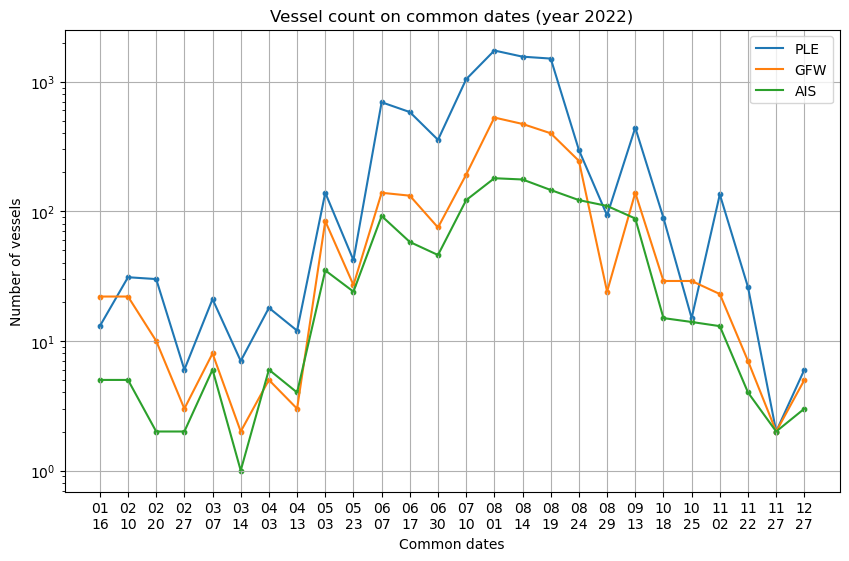

['5_20220116', '5_20220210', '5_20220220', '5_20220227', '5_20220307', '5_20220314', '5_20220403', '5_20220413', '5_20220503', '5_20220523', '5_20220607', '5_20220617', '5_20220630', '5_20220710', '5_20220801', '5_20220814', '5_20220819', '5_20220824', '5_20220829', '5_20220913', '5_20221018', '5_20221025', '5_20221102', '5_20221122', '5_20221127', '5_20221227']


In [18]:
aoi_id = 5
yearmon_list = list(range(202201, 202213))

all_dates = []
all_names = []
all_ais_counts = []
all_gfw_counts = []
all_ple_counts = []

for yearmon in yearmon_list:

    # Load ais
    gdf_ais = gpd.read_file(f'../AIS/database/data_rearranged/ais_{aoi_id}_{yearmon}.csv')
    gdf_ais = gdf_ais.apply(pd.to_numeric, errors='coerce')
    gdf_ais = gdf_ais.dropna(subset=['latitude', 'longitude'])

    # Load gfw 
    gdf_gfw = gpd.read_file(f'../GFW/database/data_rearranged/gfw_{aoi_id}_{yearmon}.csv')
    gdf_gfw = gdf_gfw.apply(pd.to_numeric, errors='coerce')
    gdf_gfw = gdf_gfw.dropna(subset=['latitude', 'longitude'])

    # Load ple 
    gdf_ple = gpd.read_file(f'../PLE/database/data_rearranged/ple_{aoi_id}_{yearmon}.csv')
    gdf_ple = gdf_ple.apply(pd.to_numeric, errors='coerce')
    gdf_ple = gdf_ple.dropna(subset=['latitude', 'longitude'])

    # Keep only common dates
    common_dates = gdf_ais['date'].isin(gdf_gfw['date']) & gdf_ais['date'].isin(gdf_ple['date'])
    gdf_ais = gdf_ais[common_dates]
    gdf_gfw = gdf_gfw[gdf_gfw['date'].isin(gdf_ais['date'])]
    gdf_ple = gdf_ple[gdf_ple['date'].isin(gdf_ais['date'])]

    # count number of objects per date
    ais_counts = gdf_ais['date'].value_counts()
    gfw_counts = gdf_gfw['date'].value_counts()
    ple_counts = gdf_ple['date'].value_counts()

    # Combine counts into a single DataFrame
    all_ais_counts += [count for count in ais_counts]
    all_gfw_counts += [count for count in gfw_counts]
    all_ple_counts += [count for count in ple_counts]
    all_dates += [str(date)[-4:-2] + f"\n{str(date)[-2:]}" for date in gdf_ais['date'].unique()]
    all_names += [f"{aoi_id}_{date}" for date in gdf_ais['date'].unique()]

plt.figure(figsize=(10, 6))

plt.plot(all_ple_counts, label='PLE')
plt.scatter(range(len(all_dates)), all_ple_counts, s=10)

plt.plot(all_gfw_counts, label='GFW')
plt.scatter(range(len(all_dates)), all_gfw_counts, s=10)
plt.plot(all_ais_counts, label='AIS')
plt.scatter(range(len(all_dates)), all_ais_counts, s=10)
plt.xlabel('Common dates')
plt.ylabel('Number of vessels')
plt.xticks(ticks=range(len(all_dates)), labels=all_dates)
plt.title('Vessel count on common dates (year 2022)')
plt.legend()
plt.yscale('log')
plt.grid()
plt.show()

print(all_names)

Compare PLE and AIS counts over time

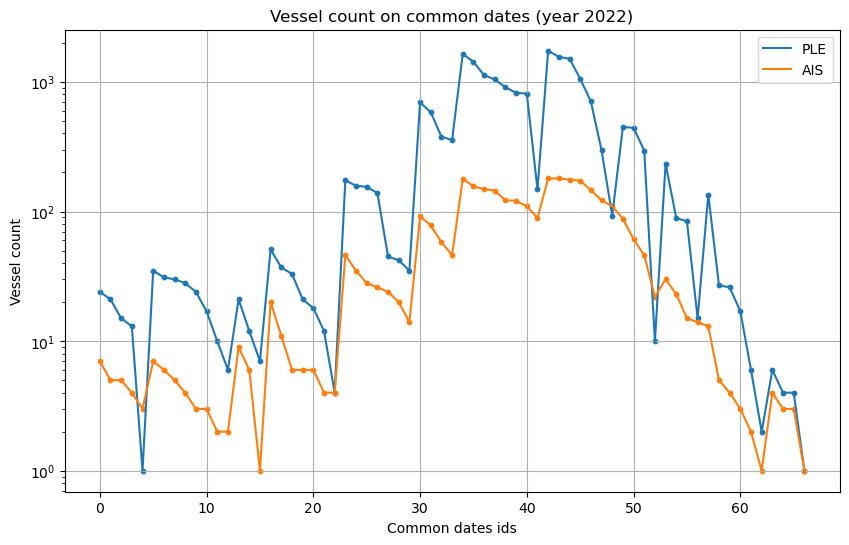

['5_20220107', '5_20220112', '5_20220116', '5_20220124', '5_20220130', '5_20220203', '5_20220210', '5_20220206', '5_20220218', '5_20220224', '5_20220220', '5_20220227', '5_20220228', '5_20220307', '5_20220314', '5_20220328', '5_20220403', '5_20220407', '5_20220410', '5_20220413', '5_20220419', '5_20220417', '5_20220425', '5_20220503', '5_20220509', '5_20220520', '5_20220515', '5_20220523', '5_20220529', '5_20220530', '5_20220607', '5_20220617', '5_20220624', '5_20220630', '5_20220703', '5_20220704', '5_20220710', '5_20220711', '5_20220718', '5_20220724', '5_20220726', '5_20220731', '5_20220801', '5_20220807', '5_20220810', '5_20220814', '5_20220819', '5_20220824', '5_20220829', '5_20220909', '5_20220913', '5_20220922', '5_20220927', '5_20221006', '5_20221014', '5_20221018', '5_20221025', '5_20221102', '5_20221110', '5_20221118', '5_20221122', '5_20221120', '5_20221127', '5_20221213', '5_20221211', '5_20221220', '5_20221227']
67


In [19]:
aoi_id = 5
yearmon_list = list(range(202201, 202213))

all_names = []
all_dates = []
all_ais_counts = []
all_ple_counts = []

for yearmon in yearmon_list:

    # Load ais
    gdf_ais = gpd.read_file(f'../AIS/database/data_rearranged/ais_{aoi_id}_{yearmon}.csv')
    gdf_ais = gdf_ais.apply(pd.to_numeric, errors='coerce')
    gdf_ais = gdf_ais.dropna(subset=['latitude', 'longitude'])

    # Load ple 
    gdf_ple = gpd.read_file(f'../PLE/database/data_rearranged/ple_{aoi_id}_{yearmon}.csv')
    gdf_ple = gdf_ple.apply(pd.to_numeric, errors='coerce')
    gdf_ple = gdf_ple.dropna(subset=['latitude', 'longitude'])

    # Keep only common dates
    common_dates = gdf_ais['date'].isin(gdf_ple['date'])

    gdf_ais = gdf_ais[common_dates]
    gdf_ple = gdf_ple[gdf_ple['date'].isin(gdf_ais['date'])]

    # count number of objects per date
    ais_counts = gdf_ais['date'].value_counts()
    ple_counts = gdf_ple['date'].value_counts()

    # Combine counts into a single DataFrame
    all_ais_counts += [count for count in ais_counts]
    all_ple_counts += [count for count in ple_counts]
    all_dates += [str(date)[-4:-2] for date in gdf_ais['date'].unique()]
    all_names += [f"{aoi_id}_{date}" for date in gdf_ais['date'].unique()]



plt.figure(figsize=(10, 6))

plt.plot(all_ple_counts, label='PLE')
plt.scatter(range(len(all_dates)), all_ple_counts, s=10)

# plt.plot(all_gfw_counts, label='GFW')
# plt.scatter(range(len(all_dates)), all_gfw_counts, s=10)
plt.plot(all_ais_counts, label='AIS')
plt.scatter(range(len(all_dates)), all_ais_counts, s=10)
plt.xlabel('Common dates ids')
plt.ylabel('Vessel count')
# plt.xticks(ticks=range(len(all_dates)), labels=all_dates)
plt.title('Vessel count on common dates (year 2022)')
plt.yscale('log')
plt.legend()
plt.grid()
plt.show()

print(all_names)
print(len(all_names))

Finding the relationship of AIS and PLE counts

Slope: 1.2443227034130289
Intercept: 0.5616483105266132
R²: 0.8882311951059929


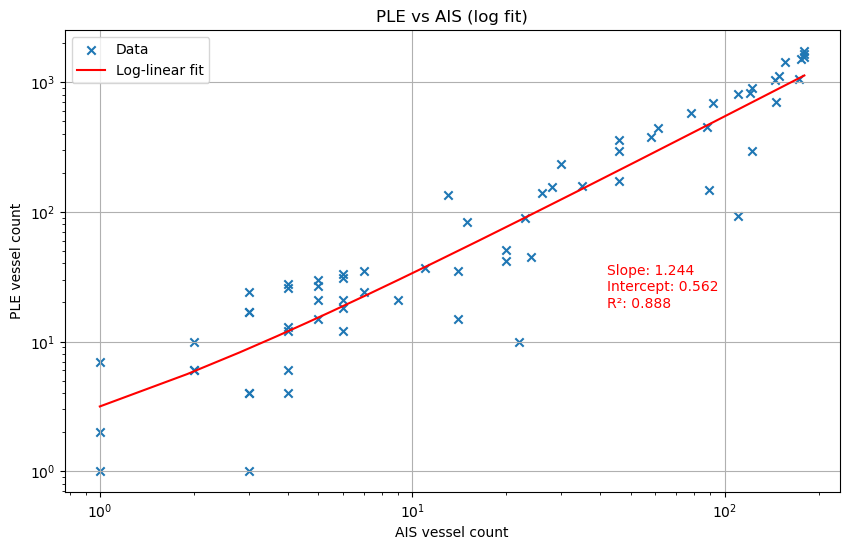

In [20]:
# Example DataFrame (you already have df)
df = pd.DataFrame({
    "AIS": all_ais_counts,
    "PLE": all_ple_counts
})

# apply log fit on PLE vs AIS
plt.figure(figsize=(10,6))
plt.scatter(df["AIS"], df["PLE"], label="Data", marker='x')

# Fit a log-linear model
X = np.log(df["AIS"] + 1).values.reshape(-1,1)
y = np.log(df["PLE"] + 1).values
reg = LinearRegression().fit(X, y)  

# Predict values
x_range = np.linspace(df["AIS"].min(), df["AIS"].max(), 200).reshape(-1,1)
y_pred = np.exp(reg.predict(np.log(x_range + 1))) - 1
# evaluate the regression model
print("Slope:", reg.coef_[0])
print("Intercept:", reg.intercept_)
print("R²:", reg.score(X, y))

slope = round(reg.coef_[0], 3)
intercept = round(reg.intercept_, 3)
r2 = round(reg.score(X, y), 3)

# add this to the plot

plt.plot(x_range, y_pred, color="red", label="Log-linear fit")
plt.text(0.7, 0.4, f"Slope: {slope}\nIntercept: {intercept}\nR²: {r2}", transform=plt.gca().transAxes, c="red")

plt.xlabel("AIS vessel count")
plt.ylabel("PLE vessel count")
plt.title("PLE vs AIS (log fit)")
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.grid()
plt.show()


